In [17]:
import pickle
import numpy as np
import json

In [18]:
with open('data/cellphy_toy_set.phy', 'r') as f:
    phy_file_raw = f.readlines()

labels = [line.split(' ')[0] for line in phy_file_raw[1:]]
labels += ["Dummy"]

In [19]:
# with open('results/cellphy_toy_data/False/10/2023-10-24-163116/results.p', 'rb') as f:
with open('results/cellphy_toy_data/False/1000/2023-10-27-211120/results.p', 'rb') as f:
    data = pickle.load(f)

data["best_jump_chain"].shape

(1000, 325)

In [20]:
index_of_best = np.argmax(data["log_weights"][data["best_epoch"]][-1])
best = data["best_jump_chain"][index_of_best]

In [21]:
class Leaf:
    def __init__(self, value):
        self.value = value
        self.parent = None

    def has(self, value):
        return self.value == value
    
    def find(self, value):
        if self.value == value:
            return self
        else:
            return None

    def __str__(self):
        return str(self.value)

class Inner:
    def __init__(self, left, right):
        self.left = left
        self.right = right

        left.parent = self
        right.parent = self

        self.parent = None

    def has(self, value):
        return self.left.has(value) or self.right.has(value)
    
    def find(self, value):
        return self.left.find(value) or self.right.find(value)

    def __str__(self):
        return f"({self.left},{self.right})"

def build_tree(jc):
    """Returns the Newick representation of the tree represented by the jump chain"""
    entries = [[labels[int(y[1:])] for y in str(x)[2:-1].split("+")] for x in np.unique(jc[1:])]
    entries = sorted(entries, key=lambda x: len(x))

    trees = []

    for entry in entries:
        if len(entry) == 1:
            trees.append(Leaf(entry[0]))
        else:
            trees_to_merge = list(filter(lambda x: True in map(lambda y: x.has(y), entry), trees))
            if len(trees_to_merge) != 2:
                raise Exception("too many trees to merge")

            new_inner = Inner(trees_to_merge[0], trees_to_merge[1])
            trees = list(filter(lambda x: x not in trees_to_merge, trees))
            trees.append(new_inner)

    if len(trees) != 2:
        raise Exception("too many trees to merge")

    return Inner(trees[0], trees[1])

In [22]:
def re_root_tree(node, parent):
    if not node:
        return Leaf("Dummy")
    elif isinstance(node, Leaf):
        return node
    elif node.left == parent:
        return Inner(re_root_tree(node.right, node), re_root_tree(node.parent, node))
    elif node.right == parent:
        return Inner(re_root_tree(node.left, node), re_root_tree(node.parent, node))
    else: # node.parent == parent
        return node

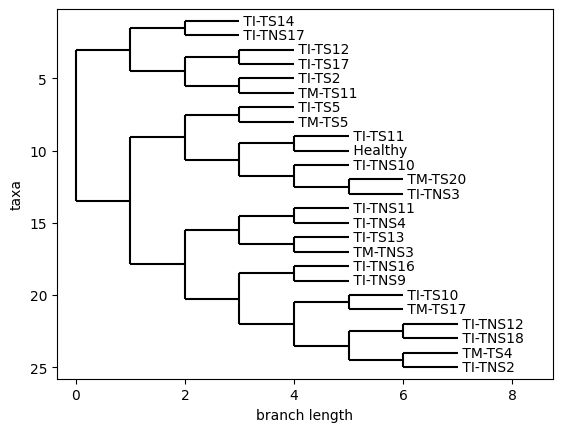

In [35]:
from Bio import Phylo
import io
import matplotlib.pyplot as plt

# Define your tree in Newick format
root = build_tree(best)

# Parse the tree
tree = Phylo.read(io.StringIO(str(root)), "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()

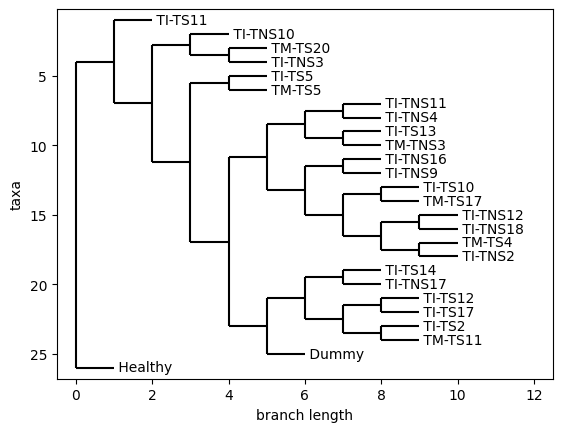

In [44]:
root = build_tree(best)
healthy = root.find("Healthy")
new_root = re_root_tree(healthy.parent, healthy)
new_root = Inner(new_root, healthy)

# Parse the tree
tree = Phylo.read(io.StringIO(str(new_root)), "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()